In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import os
import pandas as pd
import pysam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from basenji import seqnn, stream, dataset, dna_io

from akita_utils.numpy_utils import ut_dense
from akita_utils.dna_utils import dna_1hot

from helper import get_target, plot_maps_with_labels

## Akita's predictions

In [2]:
# read data parameters
mouse_dir = "/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/"
data_stats_file = '%s/statistics.json' % mouse_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

In [3]:
AkitaV2_testset_path = "/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed"
AkitaV2_testset = pd.read_csv(AkitaV2_testset_path, sep='\t', names=['chr','start','stop','type'])

In [4]:
chrom = "chr4"
start = 148432896
end = 149743616

In [5]:
AkitaV2_testset[(AkitaV2_testset["start"] < start) & (AkitaV2_testset["chr"] == chrom) & (AkitaV2_testset["stop"] > start)]

,chr,start,stop,type
94,chr4,147777536,149088256,fold0
391,chr4,148105216,149415936,fold0


In [6]:
# model's parameters
batch_size=8 
head_index = 1 # mouse!
shifts = "0"
rc = False
shifts = [int(shift) for shift in shifts.split(",")]

# directory with models
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"

In [7]:
# open genome FASTA
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa"
genome_open = pysam.Fastafile(genome_fasta)

# picking the model
model_index = 0

In [8]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [9]:
# fetching
seq_1hot = dna_1hot(
        genome_open.fetch(
            chrom, start, end
        ).upper()
    )
expanded_seq_1hot = np.expand_dims(seq_1hot, 0)

In [10]:
test_pred = seqnn_model.model.predict(expanded_seq_1hot)
test_pred_maps = ut_dense(test_pred[0,:,:])
preds = [test_pred_maps[:,:,i] for i in range(6)]

1/1 [==============================] - 3s 3s/step


In [11]:
labels = ["mESC", "mESC", "cortical neuron", "neocortex cortical neuron", "neural progenitor cell", "neocortex neural progenitor cell"]

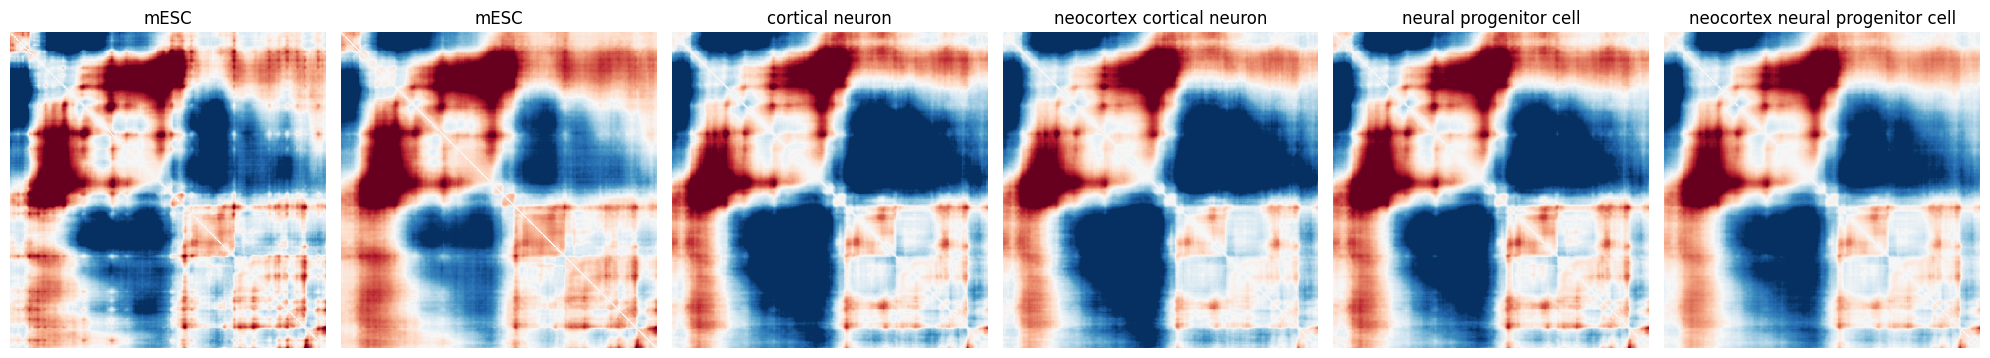

In [12]:
plot_maps_with_labels(preds, labels)

In [13]:
genome_open.close()

## Comparing with Targets

In [14]:
cool_paths = {"Hsieh2019_mESC_uC_path" : "/project/fudenber_735/GEO/Hsieh2019/4DN/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool",
"Bonev2017_mESC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES_all.mm10.mapq_30.2048.cool",
"Bonev2017_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_ncx_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_NPC_all.mm10.mapq_30.2048.cool",
"Bonev2017_ncx_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool"}

In [15]:
seq_len_nt = 1310720
padding = (640-512) // 2

In [16]:
mseq_str = '%s:%d-%d' % (chrom, start, end)

In [17]:
targets = []

for path in cool_paths:
    targets.append(get_target(cool_paths[path], padding, mseq_str))

In [18]:
for i in range(6):
    targets[i] = np.nan_to_num(targets[i], nan=0)

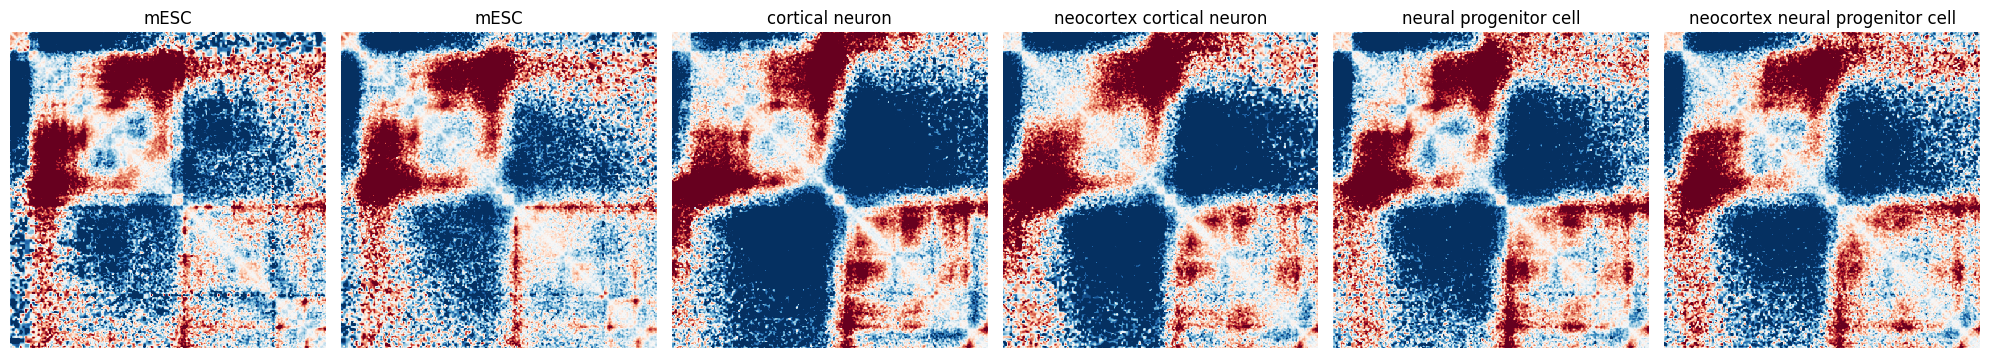

In [19]:
plot_maps_with_labels(targets, labels)